# Demonstration of Mutual Information Numerical Estimates

In [87]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import nquad
from scipy.stats import entropy, multivariate_normal
from sklearn.datasets import make_sparse_spd_matrix, make_spd_matrix

In [82]:
seed = 12345
rng = np.random.default_rng(seed)

In [83]:
def approximate_clf_mutual_information(
    means, covs, class_probs=[0.5, 0.5], base=np.exp(1), seed=None
):
    """Approximate MI for multivariate Gaussian for a classification setting.

    Parameters
    ----------
    means : list of ArrayLike of shape (n_dims_,)
        A list of means to sample from for each class.
    covs : list of ArrayLike of shape (n_dims_, n_dims_)
        A list of covariances to sample from for each class.
    class_probs : list, optional
        List of class probabilities, by default [0.5, 0.5] for
        balanced binary classification.
    base : float, optional
        The bit base to use, by default np.exp(1) for natural logarithm.
    seed : int, optional
        Random seed for the multivariate normal, by default None.

    Returns
    -------
    I_XY : float
        Estimated mutual information.
    H_X : float
        Estimated entropy of X, the mixture of multivariate Gaussians.
    H_XY : float
        The conditional entropy of X given Y.
    int_err : float
        The integration error for ``H_X``.
    """
    # this implicitly assumes that the signal of interest is between -10 and 10
    scale = 10
    n_dims = [cov.shape[1] for cov in covs]
    lims = [[-scale, scale]] * max(n_dims)

    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += class_probs[k] * multivariate_normal.pdf(x, means[k], covs[k])
        return -p * np.log(p) / np.log(base)

    # numerically integrate H(X)
    # opts = dict(limit=50)
    H_X, int_err = nquad(
        func,
        lims,
        # opts=opts
    )

    # Compute MI.
    H_XY = 0
    for k in range(len(means)):
        H_XY += (
            class_probs[k]
            * (
                n_dims[k] * np.log(2 * np.pi)
                + np.log(np.linalg.det(covs[k]))
                + n_dims[k]
            )
            / (2 * np.log(base))
        )
    I_XY = H_X - H_XY
    return I_XY, H_X, H_XY, int_err

In [65]:
def approximate_clf_mutual_information_with_H_Y(
    means, covs, n=10000, class_probs=[0.5, 0.5], base=np.exp(1), seed=None
):
    rng = np.random.default_rng(seed)
    P_Y = class_probs

    # Generate samples
    pdf_class = []
    X = []
    for i in range(len(means)):
        pdf_class.append(multivariate_normal(means[i], covs[i], allow_singular=True))
        n_dims = len(means[i])
        size = (int(n * P_Y[i]),)
        sampled_X = rng.multivariate_normal(means[i], covs[i], size=size)
        X.append(sampled_X)

    X = np.vstack(X)

    # Calculate P(X) by law of total probability
    P_X_l = []
    P_X_on_Y = []
    for i in range(len(means)):
        P_X_on_Y.append(pdf_class[i].pdf(X))
        P_X_l.append(P_X_on_Y[-1] * P_Y[i])
    P_X = sum(P_X_l)

    # Calculate P(Y|X) by Bayes' theorem
    P_Y_on_X = []
    for i in range(len(means)):
        P_Y_on_X.append((P_X_on_Y[i] * P_Y[i] / P_X).reshape(-1, 1))

    P_Y_on_X = np.hstack(P_Y_on_X)
    P_Y_on_X = P_Y_on_X[~np.isnan(P_Y_on_X)].reshape(-1, 2)

    # Calculate the entropy of Y by class counts
    H_Y = entropy(P_Y, base=base)

    # Calculate the conditional entropy of Y on X
    H_Y_on_X = np.mean(entropy(P_Y_on_X, base=base, axis=1))

    MI = H_Y - H_Y_on_X
    return MI

In [66]:
dimensions_range = range(2, 4)  # You can adjust the range based on your requirements

In [67]:
results = defaultdict(list)
base = np.exp(1)

for dim in dimensions_range:
    means = [np.zeros(dim), np.ones(dim)]
    covs = [
        np.eye(dim) * 0.5,
        np.eye(dim) * 0.5,
    ]  # Diagonal covariance matrices for simplicity
    class_probs = [0.5, 0.5]

    I_XY, _, _, int_err = approximate_clf_mutual_information(
        means, covs, class_probs=class_probs, base=base, seed=seed
    )

    I_XY_H_Y = approximate_clf_mutual_information_with_H_Y(
        means, covs, class_probs=class_probs, base=base, seed=seed
    )

    results["int_err"].append(int_err)
    results["mi_int"].append(I_XY)
    results["n_dims"].append(dim)
    results["mi_post"].append(I_XY_H_Y)

    print(f"done with {dim}")

done with 2
done with 3


In [84]:
id_results = results.copy()

In [73]:
df = pd.DataFrame(results)

df = pd.melt(
    df,
    value_name="MI",
    value_vars=("mi_int", "mi_post"),
    id_vars=("int_err", "n_dims"),
    var_name="Estimate",
)

display(df.head())

,int_err,n_dims,Estimate,MI
0,1.407698e-08,2,mi_int,0.336831
1,1.489843e-08,3,mi_int,0.431909
2,1.407698e-08,2,mi_post,0.339080
3,1.489843e-08,3,mi_post,0.429229


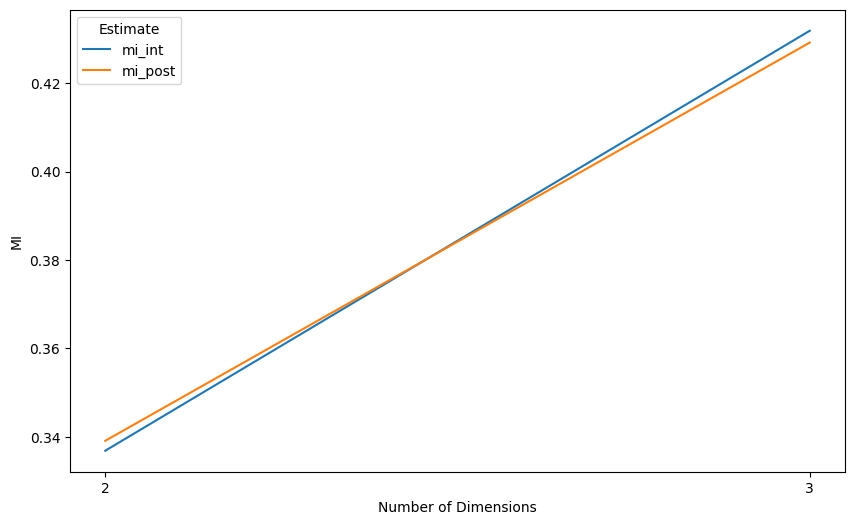

In [81]:
# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=df, x="n_dims", y="MI", hue="Estimate", ax=ax)
ax.set(xticks=np.arange(2, 4), xlabel="Number of Dimensions")
# ax = sns.scatterplot(data=df, x="int_err", y="MI", hue="Estimate", ax=axs[1])
# ax.set(
#     ylabel="Mutual Information",
#     title="Integration Error and Mutual Information vs Dimensionality",
# )
plt.show()

In [88]:
# results = defaultdict(list)
# base = np.exp(1)

for dim in dimensions_range:
    for idx in range(10):
        means = [np.zeros(dim), np.ones(dim)]
        covs = [
            make_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
            make_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
        ]
        class_probs = [0.5, 0.5]

        I_XY, _, _, int_err = approximate_clf_mutual_information(
            means, covs, class_probs=class_probs, base=base, seed=seed
        )

        I_XY_H_Y = approximate_clf_mutual_information_with_H_Y(
            means, covs, class_probs=class_probs, base=base, seed=seed
        )

        results["int_err"].append(int_err)
        results["mi_int"].append(I_XY)
        results["n_dims"].append(dim)
        results["mi_post"].append(I_XY_H_Y)

    print(f"done with {dim}")

done with 2
done with 3


,int_err,n_dims,Estimate,MI
0,1.407698e-08,2,mi_int,0.336831
1,1.489843e-08,3,mi_int,0.431909
2,1.469375e-08,2,mi_int,0.343784
3,2.838372e-08,2,mi_int,0.243000
4,1.436563e-08,2,mi_int,0.360875


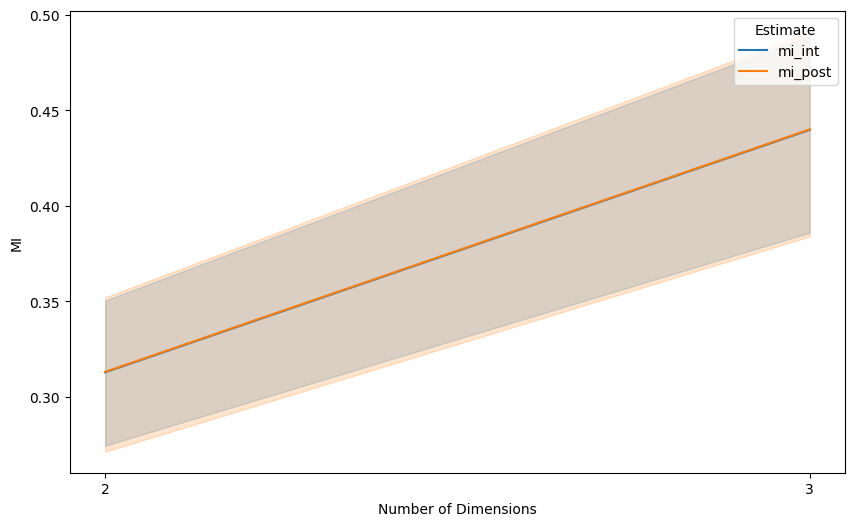

In [90]:
df = pd.DataFrame(results)

df = pd.melt(
    df,
    value_name="MI",
    value_vars=("mi_int", "mi_post"),
    id_vars=("int_err", "n_dims"),
    var_name="Estimate",
)

display(df.head())

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=df, x="n_dims", y="MI", hue="Estimate", ax=ax)
ax.set(xticks=np.arange(2, 4), xlabel="Number of Dimensions")
# ax = sns.scatterplot(data=df, x="int_err", y="MI", hue="Estimate", ax=axs[1])
# ax.set(
#     ylabel="Mutual Information",
#     title="Integration Error and Mutual Information vs Dimensionality",
# )
plt.show()

In [91]:
sparse_results = defaultdict(list)

for dim in dimensions_range:
    for idx in range(10):
        means = [np.zeros(dim), np.ones(dim)]
        covs = [
            make_sparse_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
            make_sparse_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
        ]
        class_probs = [0.5, 0.5]

        I_XY, _, _, int_err = approximate_clf_mutual_information(
            means, covs, class_probs=class_probs, base=base, seed=seed
        )

        I_XY_H_Y = approximate_clf_mutual_information_with_H_Y(
            means, covs, class_probs=class_probs, base=base, seed=seed
        )

        sparse_results["int_err"].append(int_err)
        sparse_results["mi_int"].append(I_XY)
        sparse_results["n_dims"].append(dim)
        sparse_results["mi_post"].append(I_XY_H_Y)

    print(f"done with {dim}")

done with 2
done with 3


,int_err,n_dims,Estimate,MI
0,1.055013e-08,2,mi_int,0.201345
1,1.055013e-08,2,mi_int,0.201345
2,1.055013e-08,2,mi_int,0.201345
3,1.055013e-08,2,mi_int,0.201345
4,1.055013e-08,2,mi_int,0.201345


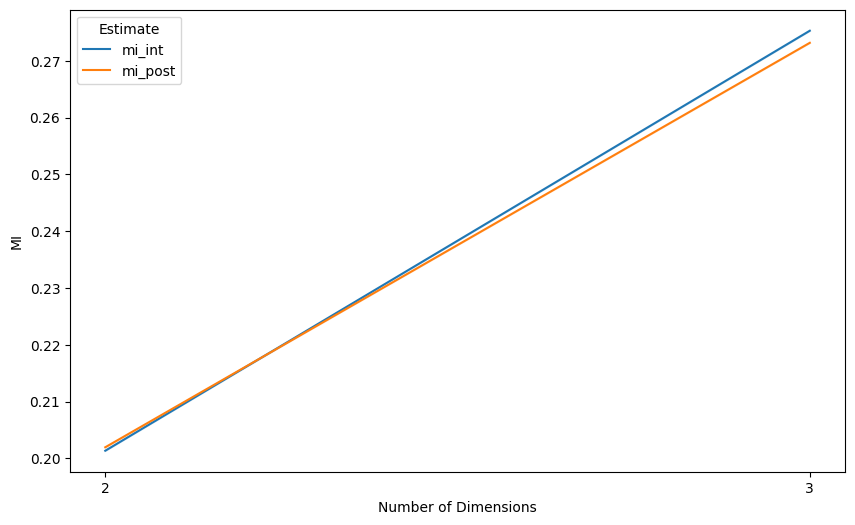

In [92]:
df = pd.DataFrame(sparse_results)

df = pd.melt(
    df,
    value_name="MI",
    value_vars=("mi_int", "mi_post"),
    id_vars=("int_err", "n_dims"),
    var_name="Estimate",
)

display(df.head())

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=df, x="n_dims", y="MI", hue="Estimate", ax=ax)
ax.set(xticks=np.arange(2, 4), xlabel="Number of Dimensions")
# ax = sns.scatterplot(data=df, x="int_err", y="MI", hue="Estimate", ax=axs[1])
# ax.set(
#     ylabel="Mutual Information",
#     title="Integration Error and Mutual Information vs Dimensionality",
# )
plt.show()

# Now vary the sample size of the posterior-approach

In [114]:
n_samples_list = np.logspace(2, 7, 6)
print(n_samples_list)

[1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07]


In [ ]:
results = defaultdict(list)

for dim in dimensions_range:
    for idx in range(10):
        means = [np.zeros(dim), np.ones(dim)]
        covs = [
            make_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
            make_spd_matrix(n_dim=dim, random_state=rng.integers(0, 1e6)),
        ]
        class_probs = [0.5, 0.5]

        I_XY, _, _, int_err = approximate_clf_mutual_information(
            means, covs, class_probs=class_probs, base=base, seed=seed
        )

        for n_samples in n_samples_list:
            I_XY_H_Y = approximate_clf_mutual_information_with_H_Y(
                means, covs, class_probs=class_probs, base=base, seed=seed, n=n_samples
            )

            results["int_err"].append(int_err)
            results["mi_int"].append(I_XY)
            results["n_dims"].append(dim)
            results["mi_post"].append(I_XY_H_Y)
            results["n_samples"].append(n_samples)

    print(f"done with {dim}")

done with 2
